# Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm

%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer


from collections import Counter

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import shap
import optuna

In [30]:
df_raw = pd.read_csv('survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


In [31]:
df_raw.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State',
       'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode',
       'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
       'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
       'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq',
       'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
       'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')

# Cleaning

## Filtering Asian Countries

In [32]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase',]

In [33]:
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.dropna(inplace=True)
df_drop.Country.unique()

array(['Spain', 'Turkey', 'Canada', 'Germany', 'Israel', 'Brazil',
       'Greece', 'Russian Federation', 'United States of America',
       'United Kingdom of Great Britain and Northern Ireland', 'Poland',
       'Switzerland', 'Hungary', 'Sweden', 'France', 'Nigeria', 'Italy',
       'Albania', 'Bangladesh', 'Netherlands', 'Romania', 'Sri Lanka',
       'India', 'Lithuania', 'Ukraine', 'Slovenia', 'Georgia', 'Denmark',
       'Ireland', 'Egypt', 'Colombia', 'Australia', 'Indonesia',
       'Iran, Islamic Republic of...', 'Portugal', 'Armenia',
       'Hong Kong (S.A.R.)', 'Argentina', 'Finland', 'Peru', 'Japan',
       'Belgium', 'United Arab Emirates', 'Bolivia', 'Austria',
       'South Africa', 'Pakistan', 'Lebanon', 'Serbia', 'Malta',
       'Czech Republic', 'Belarus', 'Kenya', 'Malaysia', 'Uruguay',
       'The former Yugoslav Republic of Macedonia', 'Botswana', 'Algeria',
       'Norway', 'China', 'Croatia', 'Mexico', 'Jordan', 'Chile',
       'Luxembourg', 'Uzbekistan', 'Syri

In [34]:
asian_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 'Sri Lanka',
                   'Georgia', 'Hong Kong (S.A.R.)', 'Japan', 'United Arab Emirates', 
                   'Turkey', 'Pakistan', 'Lebanon', 'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                   'Syrian Arab Republic', 'Taiwan', 'South Korea', 'Viet Nam', 
                   "Lao People's Democratic Republic", 'Nepal', 'Philippines', 'Azerbaijan', 
                   'Saudi Arabia', 'Singapore', 'Armenia', 'Cyprus', 'Kuwait', 'Thailand', 
                   'Myanmar', 'Kazakhstan', 'Iraq', 'Bahrain', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 
                   'Republic of Korea', 'Tajikistan', 'Oman', 'Palestine', 'Afghanistan', 'Mongolia', 'Maldives',
                   'Qatar', 'Turkmenistan'
                  ]
df_asia = df_drop[df_drop['Country'].isin(asian_countries)]
df_asia

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,17748.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,2,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,7,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4,2,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83355,83356,I am a developer by profession,Employed full-time,Japan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,3,"Developer, front-end;Developer, desktop or ent...",20 to 99 employees,C#;HTML/CSS;JavaScript;SQL;TypeScript,Microsoft SQL Server,AWS,Windows,Less than once per month or monthly,450.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,5,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,7020.0
83402,83403,I am a developer by profession,Employed full-time,South Korea,"Secondary school (e.g. American high school, G...",4,Less than 1 year,"Developer, mobile;Developer, front-end;Develop...",2 to 9 employees,C;Dart;HTML/CSS;Java;JavaScript;Kotlin;Node.js,Firebase;MariaDB;MongoDB;MySQL;Oracle,AWS;Heroku,MacOS,I have never participated in Q&A on Stack Over...,18708.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,5,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,48866.0


In [35]:
df_asia.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'OpSys', 'SOPartFreq', 'ConvertedCompYearly'],
      dtype='object')

In [36]:
# OHE_list = []
# ordinal_list = []
# for col in df_asia.columns:
#     print(col, '\n--------------')
#     display(df_asia[col].unique())
#     ans = input('action')
#     if ans == 'cat':
#         OHE_list.append(col)
#     elif ans == 'ord':
#         ordinal_list.append(col)

In [37]:
OHE_list = ['Employment', 'Country', 'OpSys']

In [38]:
ordinal_list = ['MainBranch', 'EdLevel', 'OrgSize', 'SOPartFreq']

**Columns that need transformation**

In [39]:
df_asia[df_asia.columns.difference(OHE_list+ordinal_list)].head()

,ConvertedCompYearly,DatabaseHaveWorkedWith,DevType,LanguageHaveWorkedWith,PlatformHaveWorkedWith,ResponseId,YearsCode,YearsCodePro
16,17748.0,Microsoft SQL Server;MongoDB;PostgreSQL,"Developer, full-stack",C#;HTML/CSS;Java;JavaScript;Node.js,AWS;Google Cloud Platform,17,6,2
58,22644.0,Oracle,"Developer, full-stack;Data scientist or machin...",Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Heroku,59,5,3
148,36000.0,SQLite,Database administrator;Data or business analyst,SQL,Google Cloud Platform,149,2,2
154,2340.0,Firebase;MariaDB;MongoDB;MySQL;Redis,"Developer, front-end;Developer, full-stack;Dev...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Heroku,155,20,7
168,14844.0,SQLite,"Developer, front-end;Engineer, data;Developer,...",HTML/CSS;JavaScript;Python;SQL,DigitalOcean;Heroku,169,4,2


## Prepping Features with top X filtering

In [40]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_asia[col_name].str.split(';'):
         li = li + row

    df_try = df_asia[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [41]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 12, 'Lang')
lang_OHE

,Lang_JavaScript,Lang_HTML/CSS,Lang_SQL,Lang_Python,Lang_Node.js,Lang_Java,Lang_TypeScript,Lang_PHP,Lang_C#,Lang_C++,Lang_Bash/Shell,Lang_C
index,,,,,,,,,,,,
16,1,1,0,0,1,1,0,0,1,0,0,0
58,1,1,1,1,0,0,0,0,0,0,1,0
148,0,0,1,0,0,0,0,0,0,0,0,0
154,1,1,1,1,1,0,0,1,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83355,1,1,1,0,0,0,1,0,1,0,0,0
83356,1,0,1,1,1,1,1,1,1,1,1,1
83402,1,1,0,0,1,1,0,0,0,0,0,1


In [42]:
devtype_OHE = OHE_semicolon_vals('DevType', 10, 'Dev')
devtype_OHE

,"Dev_Developer, full-stack","Dev_Developer, back-end","Dev_Developer, front-end","Dev_Developer, mobile","Dev_Developer, desktop or enterprise applications",Dev_DevOps specialist,Dev_Database administrator,Dev_System administrator,"Dev_Engineer, data",Dev_Data scientist or machine learning specialist
index,,,,,,,,,,
16,1,0,0,0,0,0,0,0,0,0
58,1,0,0,0,0,0,0,0,0,1
148,0,0,0,0,0,0,1,0,0,0
154,1,1,1,0,0,1,1,1,0,0
168,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
83355,1,1,1,0,1,0,0,0,0,0
83356,1,1,1,1,1,0,1,1,1,1
83402,0,0,1,1,1,0,0,0,0,0


In [43]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 10, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_MongoDB,DB_SQLite,DB_Redis,DB_Microsoft SQL Server,DB_Firebase,DB_Elasticsearch,DB_MariaDB,DB_Oracle
index,,,,,,,,,,
16,0,1,1,0,0,1,0,0,0,0
58,0,0,0,0,0,0,0,0,0,1
148,0,0,0,1,0,0,0,0,0,0
154,1,0,1,0,1,0,1,0,1,0
168,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
83355,0,0,0,0,0,1,0,0,0,0
83356,1,1,1,1,1,0,1,0,1,0
83402,1,0,1,0,0,0,1,0,1,1


In [44]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 10, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_Microsoft Azure,Plat_Heroku,Plat_DigitalOcean,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,
16,1,1,0,0,0,0,0
58,0,0,0,1,0,0,0
148,0,1,0,0,0,0,0
154,0,0,0,1,0,0,0
168,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...
83355,1,0,0,0,0,0,0
83356,1,1,1,1,1,1,0
83402,1,0,0,1,0,0,0


Changing `YearsCode` and `YearsCodeProd` to numeric

In [45]:
#YearsCode
df_asia['YearsCode'] = df_asia['YearsCode'].copy().apply(lambda x: 0.5 if x == 'Less than 1 year' else int(x))
#YearsCodePro
df_asia['YearsCodePro'] = df_asia['YearsCodePro'].copy().apply(lambda x: 0.5 if x == 'Less than 1 year' else int(x))



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Ordinal Mapping 

In [46]:
df_asia['MainBranch'].unique()
MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_asia['MainBranch'] = df_asia['MainBranch'].copy().map(MainBranch_mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_asia['EdLevel'] = df_asia['EdLevel'].copy().map(EdLevel_mapping)
# df_asia
# df_asia['EdLevel']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_asia['OrgSize'] = df_asia['OrgSize'].copy().map(OrgSize_mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
df_asia['SOPartFreq'].unique()

SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_asia['SOPartFreq'] = df_asia['SOPartFreq'].copy().map(SOPartFreq_mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
df_asia[ordinal_list]

,MainBranch,EdLevel,OrgSize,SOPartFreq
16,1,5,5,5
58,0,8,4,1
148,0,6,1,5
154,1,5,1,4
168,1,3,1,4
...,...,...,...,...
83355,1,5,4,1
83356,1,5,1,0
83402,1,2,2,0
83411,1,5,5,1


## OHE

In [51]:
df_asia[OHE_list]

,Employment,Country,OpSys
16,Employed full-time,Turkey,Windows
58,Employed full-time,Russian Federation,Linux-based
148,"Independent contractor, freelancer, or self-em...",Sri Lanka,Windows
154,"Independent contractor, freelancer, or self-em...",India,Windows
168,"Independent contractor, freelancer, or self-em...",Georgia,Linux-based
...,...,...,...
83355,Employed full-time,Japan,Windows
83356,"Independent contractor, freelancer, or self-em...",Indonesia,Windows Subsystem for Linux (WSL)
83402,Employed full-time,South Korea,MacOS
83411,Employed full-time,India,MacOS


In [52]:
df_asia['ConvertedCompYearly'] = df_asia['ConvertedCompYearly'].astype(int)
numeric_data = df_asia.select_dtypes(['int', 'float'])
numeric_data.index.name='index'
numeric_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly
index,,,,,,,,
16,17,1,5,6.0,2.0,5,5,17748
58,59,0,8,5.0,3.0,4,1,22644
148,149,0,6,2.0,2.0,1,5,36000
154,155,1,5,20.0,7.0,1,4,2340
168,169,1,3,4.0,2.0,1,4,14844
...,...,...,...,...,...,...,...,...
83355,83356,1,5,8.0,3.0,4,1,450
83356,83357,1,5,11.0,5.0,1,0,7020
83402,83403,1,2,4.0,0.5,2,0,18708


In [53]:
OHE_data = pd.concat([lang_OHE,database_OHE, devtype_OHE, platform_OHE, pd.get_dummies(df_asia[OHE_list])], axis=1)
df_final = pd.merge(left=numeric_data, right=OHE_data, left_index=True, right_index=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_JavaScript,Lang_HTML/CSS,...,Country_Turkmenistan,Country_United Arab Emirates,Country_Uzbekistan,Country_Viet Nam,OpSys_BSD,OpSys_Linux-based,OpSys_MacOS,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL)
index,,,,,,,,,,,,,,,,,,,,,
16,17,1,5,6.0,2.0,5,5,17748,1,1,...,0,0,0,0,0,0,0,0,1,0
58,59,0,8,5.0,3.0,4,1,22644,1,1,...,0,0,0,0,0,1,0,0,0,0
148,149,0,6,2.0,2.0,1,5,36000,0,0,...,0,0,0,0,0,0,0,0,1,0
154,155,1,5,20.0,7.0,1,4,2340,1,1,...,0,0,0,0,0,0,0,0,1,0
168,169,1,3,4.0,2.0,1,4,14844,1,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83355,83356,1,5,8.0,3.0,4,1,450,1,1,...,0,0,0,0,0,0,0,0,1,0
83356,83357,1,5,11.0,5.0,1,0,7020,1,0,...,0,0,0,0,0,0,0,0,0,1
83402,83403,1,2,4.0,0.5,2,0,18708,1,1,...,0,0,0,0,0,0,1,0,0,0


# EDA

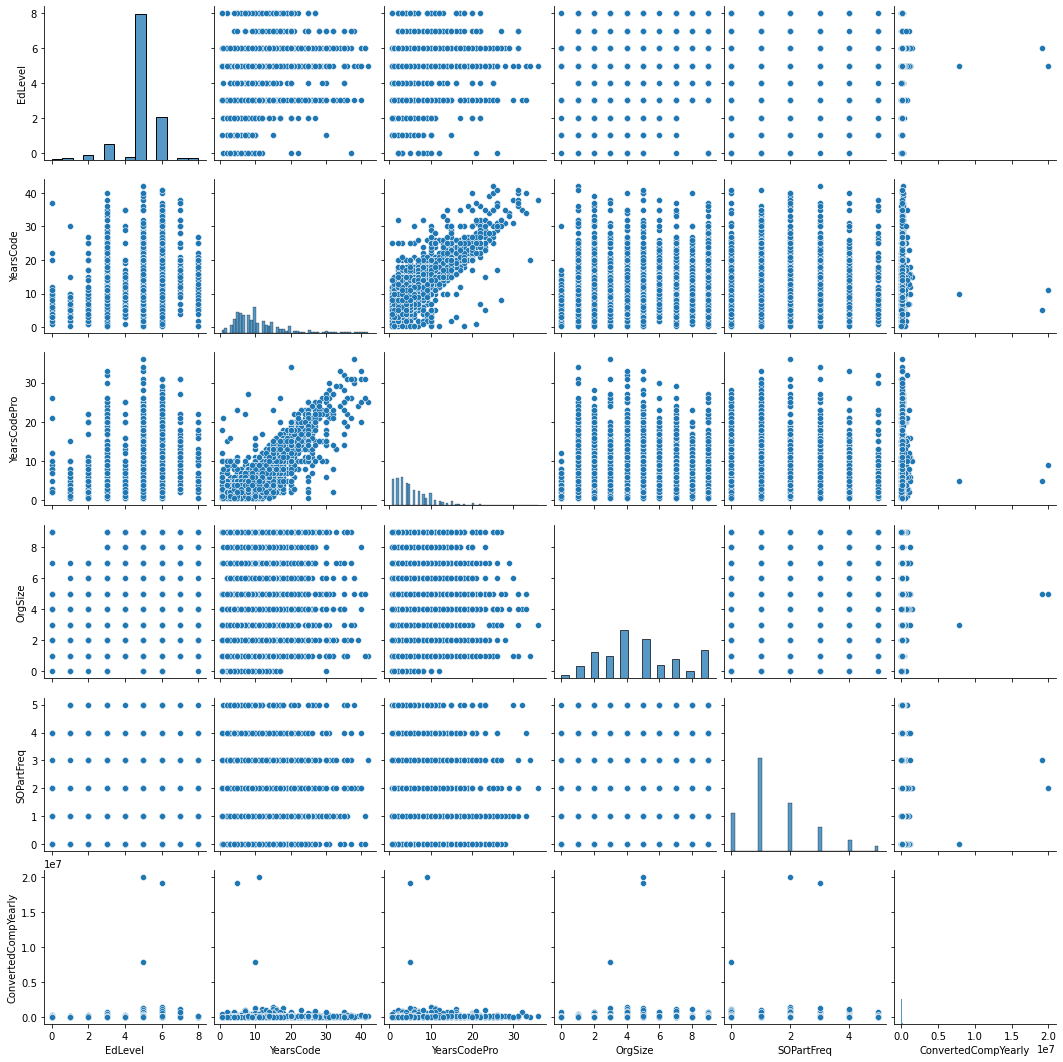

In [54]:
sns.pairplot(data=df_final[['EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'SOPartFreq', 'ConvertedCompYearly']], diag_kind='hist')
plt.show()

Skewed features may need log transformation to improve model results. idk yet will initially try running models on not transformed data

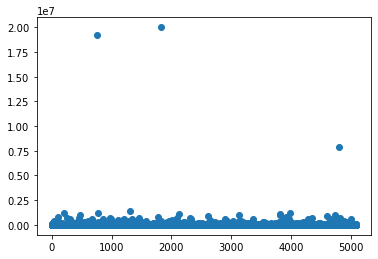

In [55]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

In [56]:
idx_outliers_y = df_final['ConvertedCompYearly'].sort_values(ascending=False).head(3).index.to_list()
df_final = df_final.drop(idx_outliers_y, axis=0)

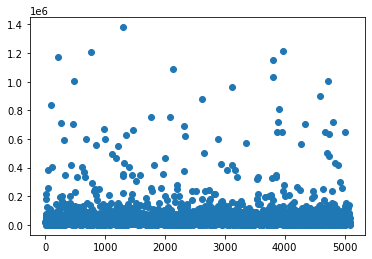

In [57]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

# ML

In [58]:
X = df_final[df_final.columns.difference(['ConvertedCompYearly', 'ResponseId'])]
y = df_final['ConvertedCompYearly']

In [59]:
# y = y.apply(np.log)
y.sort_values(ascending=False)

index
21926    1380000
64387    1212996
12793    1206288
3640     1172784
61320    1153104
          ...   
82198         12
22162         10
37761          6
22032          3
15163          2
Name: ConvertedCompYearly, Length: 5087, dtype: int32

## Logged y

since y is initially skewed

In [60]:

y = np.log(y)
y

index
16        9.784028
58       10.027650
148      10.491274
154       7.757906
168       9.605351
           ...    
83355     6.109248
83356     8.856518
83402     9.836707
83411    10.796837
83431     9.365291
Name: ConvertedCompYearly, Length: 5087, dtype: float64

## Train-Test Split

In [61]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25)

## CV

In [62]:
# from sklearn.ensemble import RandomForestRegressor

# rf_test = RandomForestRegressor()
# rf_test.fit(X_trainval, y_trainval)
# rf_test_pred = rf_test.predict(X_holdout)
# mean_absolute_error(y_holdout, rf_test_pred)

In [63]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,15)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features)
        scaler = MinMaxScaler()
        
        rf_pipe = Pipeline(steps = [['scale', scaler],['rf', model]])
        
        cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
        # cr_val = cross_val_score(model, X, y, cv=5, scoring='r2')
        return np.mean(cr_val)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=70, n_jobs=4)
    return study, optimize

In [64]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-11-25 20:51:20,749] A new study created in memory with name: no-name-254f6c22-b115-4dfe-a1d5-5e7f6ed93fee
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-11-25 20:51:22,181] Trial 3 finished with value: 0.6535236276932487 and parameters: {'n_estimators': 20, 'max_depth': 12, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6535236276932487.
[I 2021-11-25 20:51:26,964] Trial 4 finished with value: 0.6549002515815399 and parameters: {'n_estimators': 110, 'max_depth': 9, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6535236276932487.
[I 2021-11-25 20:51:29,264] Trial 2 finished with value: 0.7488992781626733 and parameters: {'n_estimators': 400, 'max_depth': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.6535236276932487.
[I 2021-11-25 20:51:29,761] Trial 0 finished with value: 0.7523063728586932 and parameters: {'n_estimators': 420, 'max_depth': 4, 

In [65]:
rf_study.best_params

{'n_estimators': 390, 'max_depth': 15, 'max_features': 'sqrt'}

In [66]:
rf = RandomForestRegressor(**rf_study.best_params)
rf.fit(X_trainval, y_trainval)
rf_pred = rf.predict(X_holdout)

mean_absolute_error(np.exp(y_holdout), np.exp(rf_pred)) # 29278.242137076086 if outliers are not removed
# 23178.36998786975 at 40 trials
# 23220.71876838312 at 70 trials

23222.97967427791

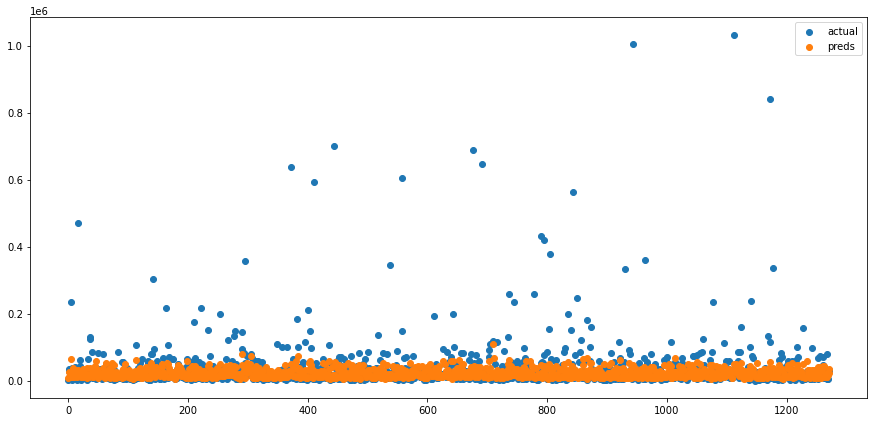

In [67]:
y_holdout_plot = y_holdout.reset_index().drop(columns='index', axis=0)


fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(y_holdout_plot.index, np.exp(y_holdout_plot), label='actual')
plt.scatter(y_holdout_plot.index, np.exp(rf_pred), label='preds')
plt.legend()
# plt.ylim(0, 400000)

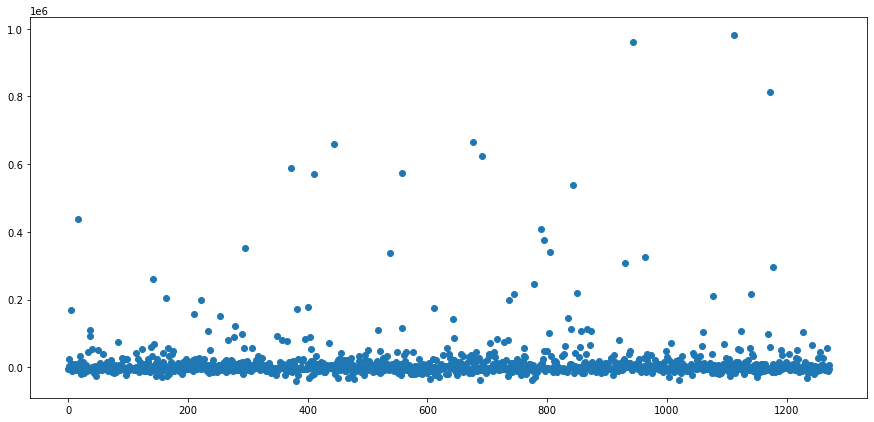

In [68]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(range(len(rf_pred)), np.exp(y_holdout) - np.exp(rf_pred))

In [69]:
np.exp(y_holdout) - np.exp(rf_pred)

index
71995    -5412.597530
33937     2809.306324
22596    23984.198538
40292     -911.224247
22987     4835.675817
             ...     
4427     55578.881704
32644    -7489.780589
40778   -10743.755265
54255     7665.940959
75879    -5807.940907
Name: ConvertedCompYearly, Length: 1272, dtype: float64

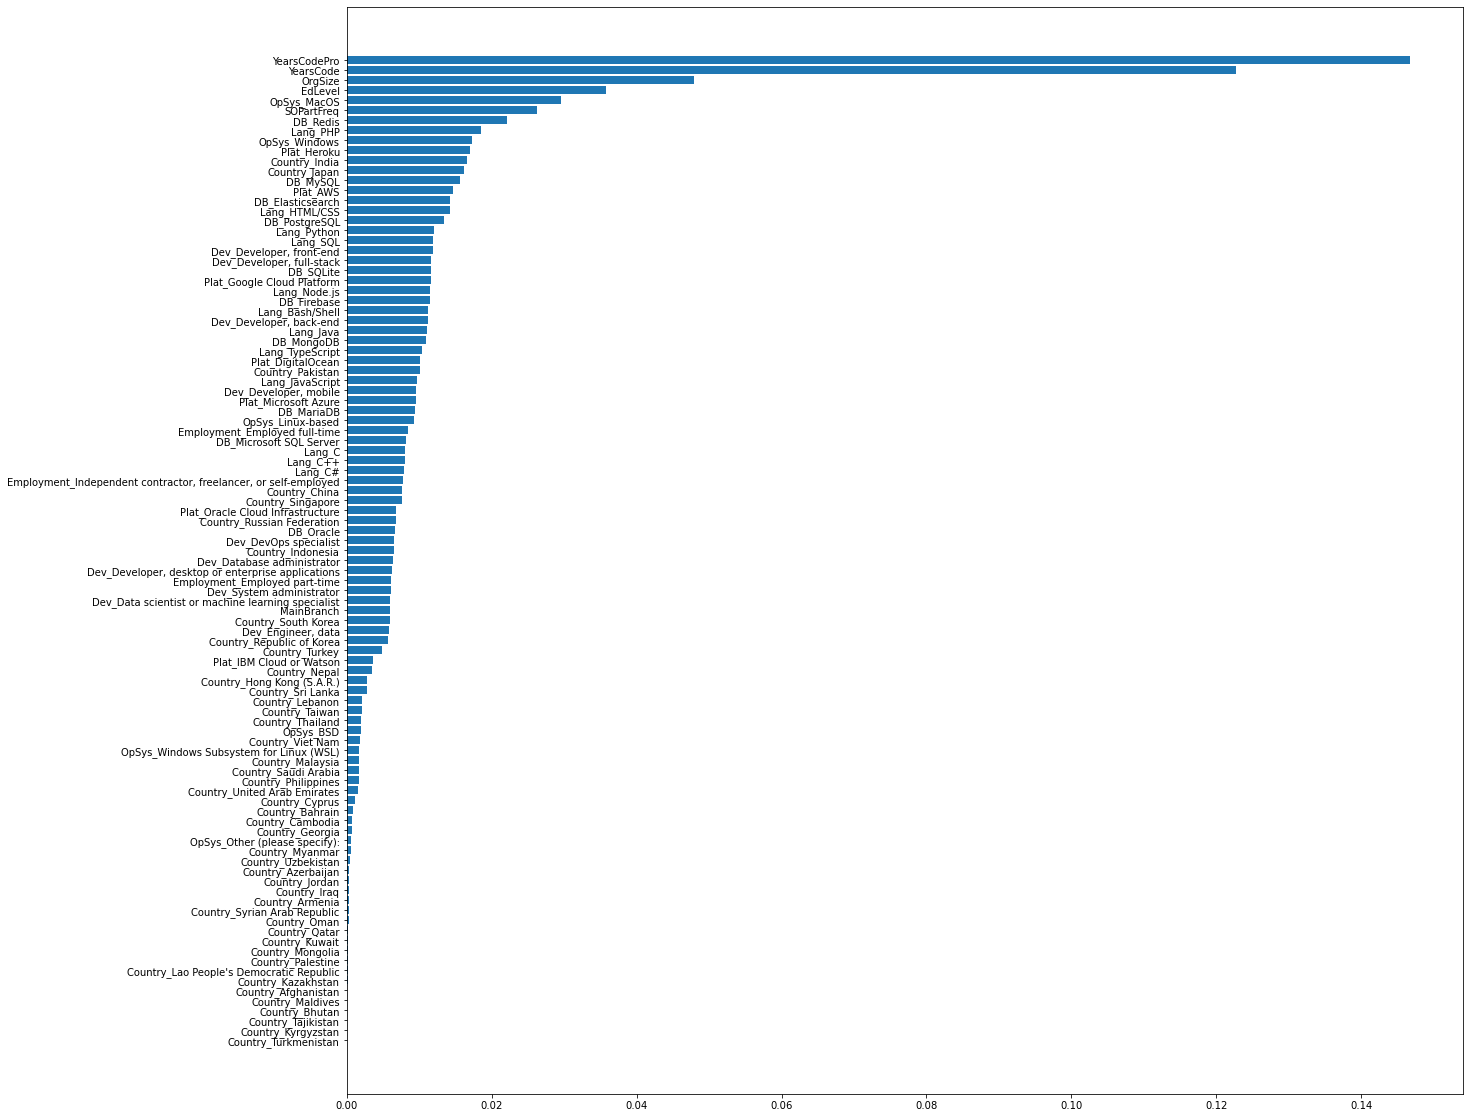

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
plt.barh(X.columns[rf.feature_importances_.argsort()], rf.feature_importances_[rf.feature_importances_.argsort()])
plt.autoscale()
plt.savefig('rf_feat_imp')

In [71]:
rf.feature_importances_

array([8.21743666e-05, 3.00629221e-04, 3.56846492e-04, 8.82552029e-04,
       1.64153652e-05, 7.68429395e-04, 7.62457439e-03, 1.15323609e-03,
       6.78213205e-04, 2.83017301e-03, 1.65645316e-02, 6.51284865e-03,
       3.34013977e-04, 1.61429129e-02, 3.52886569e-04, 1.07029065e-04,
       2.28501407e-04, 5.61388252e-06, 1.24318311e-04, 2.10453504e-03,
       1.71657644e-03, 4.61425081e-05, 1.63357077e-04, 5.58982413e-04,
       3.48189521e-03, 2.39078453e-04, 1.00362043e-02, 1.48673528e-04,
       1.65632684e-03, 2.29613040e-04, 5.65748039e-03, 6.71930358e-03,
       1.68961383e-03, 7.54697608e-03, 5.95507968e-03, 2.77022760e-03,
       2.60590259e-04, 2.09911538e-03, 7.45754017e-06, 1.97549502e-03,
       4.82496914e-03, 0.00000000e+00, 1.59983256e-03, 4.12220365e-04,
       1.85347435e-03, 1.42658359e-02, 1.14823534e-02, 9.47796970e-03,
       8.19088041e-03, 1.09228113e-02, 1.56210300e-02, 6.68261594e-03,
       1.34227851e-02, 2.21114927e-02, 1.16661467e-02, 6.01451858e-03,
      